# ANALYZING AND PREDICTING HOUSE PRICES IN IRELAND 2010-2012

** Project Overview**

The goal of this project is to analyze and predict house prices in Ireland and to find a machine learning algorithm that has good predictive performance for Irish property prices. The main dataset used is the Irish residential property register. It includes Date of Sale, Price, Address and some other features of all residential properties purchased in Ireland since the 1st January 2010, as declared to the Revenue Commissioners for stamp duty purposes. A subset of this dataset (2010 until the end of 2012) is preprocessed, geocoded, linked to police stations and local economic indicators and enriched with local crime statistics from the Irish Central Statistics office for each police station. Thereafter, various machine learning models are trained and refined to find a model that accurately predicts the transaction price of a property from its features. 

** Problem Statement and Approach**

Find a machine learning algorithm (and corresponding hyperparameters) that accurately predicts Irish property transaction prices from the given (and some constructed) features. The first step to achieve this is to initialize and preprocess the data and to map additional features that may have predictive power, such as local income per capita and crime statistics (Section 1). The next step is to explore and visualize the main features in the data and their relationships (Section 2). The third step is to run various regression algorithms in order to get a big picture of their performance on this dataset (Section 3). The fourth step is to perform hyperparameter tuning for the parameters of the best performing algorithms in the previous step (Section 4). Finally, in the last step, the results of analyzing predictive performance for the tuned algorithms applied to a test data set are reported (Section 5). 

The expectation is that some of the constructed features, such as income per capita, have strong predictive power. Moreover, it is expected that a random forest algorithm is among the best performing ones, since these types of algorithms are commonly used for predicting house prices.

** Metrics **

For measuring and comparing the performance of different algorithms, mean squared error (MSE) is used. This	measure	is appropriate, since for the regression problem at hand, we need a measure that captures the deviations of the data from the approximated function	in a continuous	way	(as	opposed	to the discrete nature of classification problems). Now, many functions satisfy	this requirement and have desirable properties, such as the absolute value function (leading to the mean absolute error), the square function (leading to the mean squared error), or a function that takes the error to the fourth power. For the house price prediction problem, it is debatable whether the mean squared error is the most appropriate model, since one can make an argument for other loss functions, such as mean absolute deviation, as well. The decision on which loss function to use ultimately is a decision on how to trade of larger errors with smaller ones. The mean squared	error provides a sensible tradeoff between large and small deviations and hence is a good choice for this house price prediction problem.


** Overview of main variables/features **

The main variables of interest are the following:
* Date - date of the property transaction
* Address - street addres of the property
* FullPrice - full transaction price, incl. value added tax
* Income_2014 - county income per capita in 2014
* Income_growth_5y - country 5-year-income-growth 2009-2014
* (Lon_x, Lat_x) - (latitude, longitude) of property transacted
* ClosestCenterDist - the distance in km to the next Irish population center (example: distance to the center of Dublin)
* CrimeIntensity - a local measure of crime intensity (constructed as the total number of crimes reported by the closest police station in 2014 over all transacted properties in the vicinity of the police station -> this serves as a proxy for population density around a station)
* NewBuilding - dummy variable if building is new (and bought from contractor/construction company)
* SizeAvailable - dummy variable indicating whether size measure is available (generally only available for new buildings)
* (SizeBig, SizeMedium, SizeSmall) - dummy variable indicating property size class

Note: Because the full dataset contains more than 185000 transactions (March 2016) and the Google geocoding-service is subject to rate limits (2500/day), we use a subset of the data consisting of around 55000 transations (the first transactions starting from 2010).

# 1. Initialize and preprocess data

**This section loads, preprocesses and joins the data. Some functions used in this section are implemented in the helper module for this analysis. For convenience and speed, if prepared data are already available, this data will be loaded from disc. **

The following preprocessing steps are performed:
* load property transaction data for Ireland for the years 2010 until 2015 (source: https://www.propertypriceregister.ie) and write the data into a single dataframe
* load county income per capita (2014) and 5 year income per capita growth (2009-2014) and attach it to dataframe
* geocode all addresses of the transacted properties using the Google GeoCoding API
* -> RESULTS IN DATAFILE "geocoded_transaction_data.csv"
* load crime incidents by police station (garda) in 2014
* extract police station coordinates from kml file using OpenRefine (kml source: http://www.garda.ie/stations/Default.aspx) and attach them to the crime incidences data
* find police station closest to each property and map crime data to the property
* compute number of property transactions per police station (to proxy for population density)
* compute local crime intensities by relating total incidences to the population density proxy
* compute full propery transation prices for (including VAT)
* construct varies dummy variables

In [47]:
# required imports
%matplotlib inline
import numpy as np
import pandas as pd
import helper_module as hp
import os.path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import cross_validation, grid_search, linear_model, svm, neighbors, ensemble, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

# set constants
PREPROCESSING = False  # True iff in preprocessing stage

In [2]:
# load prepared transaction data frame if available; else prepare dataframe
if os.path.isfile('./data/geocoded_transaction_data.csv'):
    data = pd.read_csv('./data/geocoded_transaction_data.csv')
else:
    transaction_data = hp.load_transaction_data()
    income_data = hp.load_income_data()
    data = pd.merge(left=transaction_data, right=income_data, how='left', left_on='County', right_on='region')
    (data['lon'], data['lat']) = (None, None)

# load crime stats data
crimes_data = pd.read_csv('./data/crimes2014_garda_stations_with_coordinates.csv', encoding='latin_1')

In [3]:
if PREPROCESSING:
    # geocode data
    data = hp.geocode_data(data, 'Address')
    # save a copy of the geocoded data to disk
    #data.to_csv('./data/geocoded_transaction_data.csv', encoding='utf-8', index=False)
    # map closest police station to values in data (move this later back to preprocessing)
    data = hp.map_closest_police(data, crimes_data)
    # map population centers to values in data
    data = hp.map_population_centers(data)
    # merge crime data 
    data = pd.merge(left=data, right=crimes_data, how='inner', left_on='ClosestPoliceId', right_index=True)
    # compute the number of property transactions per police station (this proxies population density around stations)
    data = pd.merge(left=data, right=pd.DataFrame(data['ClosestPoliceId'].value_counts()), how='left', left_on='ClosestPoliceId', right_index=True)
    data.rename(columns={0:'TransactionsPerStation'}, inplace=True)
    # compute the aggregate number of crimes per station
    data['TotalCrime'] = (data['03 ,Attempts/threats to murder, assaults, harassments and related offences'] 
    + data['04 ,Dangerous or negligent acts'] 
    + data['05 ,Kidnapping and related offences'] 
    + data['06 ,Robbery, extortion and hijacking offences'] 
    + data['07 ,Burglary and related offences']
    + data['08 ,Theft and related offences']
    + data['09 ,Fraud, deception and related offences']
    + data['10 ,Controlled drug offences']
    + data['11 ,Weapons and Explosives Offences']
    + data['12 ,Damage to property and to the environment']
    + data['13 ,Public order and other social code offences']
    + data['15 ,Offences against government, justice procedures and organisation of crime'])
    # compute crime intensity per station (total number of crimes over population density measure)
    data['CrimeIntensity'] = data['TotalCrime'] / data['TransactionsPerStation']
    # clean up column names
    data.columns = pd.Index(['Date', 'Address', 'PostalCode', 'County',
           'Price', 'NotFullPrice', 'VATExcl',
           'Description', 'SizeDescription', 'Region',
           'Income_2014', 'Income_growth_5y', 'Lon_x', 'Lat_x', 'ClosestPoliceId',
           'ClosestPoliceDist', 'ClosestCenterId', 'ClosestCenterDist', 'Station',
           'Division', 'Name', 'Lon_y', 'Lat_y',
           'AttemptsThreatsMurderAssaultsHarassments',
           'DangerousNegligentActs',
           'Kidnapping',
           'RobberyExtortionHijacking',
           'Burglary', 'Theft',
           'Fraud',
           'DrugOffences', 'WeaponsExplosives',
           'DamagePropertyEnvironment',
           'PublicOrderOffences',
           'OffencesAgainstGovernment',
           'TransactionsPerStation', 'TotalCrime', 'CrimeIntensity'],
          dtype='object')
    # convert date to pandas datetime
    data['Date'] = pd.to_datetime(data['Date'])
    # convert boolean vars to dummies
    data['NotFullPrice'] =  1 * (data['NotFullPrice']=='Yes')
    data['VATExcl'] =  1 * (data['VATExcl']=='Yes')
    data['NewBuilding'] =  1 * (data['Description']=='New Dwelling house /Apartment')
    data['SizeAvailable'] = 1 * (data['SizeDescription'].notnull())
    # create dummies for size classes of new buildings
    data['SizeBig'] = 1 * (data['SizeDescription'] == 'greater than 125 sq metres')
    data['SizeMedium'] = 1 * (data['SizeDescription'] == 'greater than or equal to 38 sq metres and less than 125 sq metres')
    data['SizeSmall'] = 1 * (data['SizeDescription'] == 'less than 38 sq metres')
    # convert price to numeric value
    data['Price'] = data['Price'].str.replace(',', '')
    data['Price'] = data['Price'].str.replace('\x80', '')
    data['Price'] = data['Price'].convert_objects(convert_numeric=True)
    # compute full price that includes value added
    data['FullPrice'] = data['Price'] + data['VATExcl'] * 0.135 * data['Price']

# 2. Exploratory Analysis

**The goal of this section is to explore the data and to visualize relationsships in the data. Lessons learned from this section can later be used for feature selection and for deciding which features are presumably the most relevant.**

In [4]:
# read the prepared dataset
def format_month(x):
    if x.month < 10:
        return '0' + str(x.month)
    else:
        return str(x.month)
data = pd.read_csv('./data/final_dataset.csv', encoding='utf8')
data['Date'] = pd.to_datetime(data['Date'])
data['Year_Month'] = data['Date'].apply(lambda x: str(x.year) + '_' + format_month(x))

In [83]:
# summary statistics of relevant variables
data[['FullPrice', 'LogFullPrice','Income_2014', 'Income_growth_5y', 'SizeAvailable', 'NewBuilding', 'CrimeIntensity', 'LogClosedCenterDist']].describe()

,FullPrice,LogFullPrice,Income_2014,Income_growth_5y,SizeAvailable,NewBuilding,CrimeIntensity,LogClosedCenterDist
count,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000
mean,220119.230938,12.032783,19497.715349,-0.767403,0.172236,0.172217,4.081446,2.763385
std,219301.672023,0.746018,1787.200959,3.715677,0.377589,0.377573,6.586146,1.648153
min,5079.000000,8.532870,15558.000000,-8.982098,0.000000,0.000000,0.025597,-3.756992
25%,113000.000000,11.635143,18011.000000,-3.059988,0.000000,0.000000,2.000000,1.548473
50%,180000.000000,12.100712,19198.000000,0.072776,0.000000,0.000000,3.184615,2.731713
75%,264999.992950,12.487485,21633.000000,2.114704,0.000000,0.000000,4.723404,3.958231
max,10000000.000000,16.118096,21633.000000,6.147891,1.000000,1.000000,112.305263,9.844706


**The table containing the summary statistics for relevant features shows that we are dealing with around 55000 transactions in total. The average observed price is EUR 220119.23, the median is EUR 180000.00. This indicates that the price distribution is somewhat skewed (see also one of the later graphs). We also compute log-prices for later use in the algorithms. This normalization step avoids scaling issues and leads to a distribution which is less skewed. The average income per capita for each county is between EUR 15558.00 and EUR 216300.00, with a mean of EUR 19497.72. The average income growth is -0.76 %, which is quite low due to an economic contraction during the observation period. The median income growth is 0.07 %. The table also reveals that property size classes ('big/medium/small') are only available for 17.2 % of the observations. It turns out that size classes are available only for new buildings. Finally, the constructed crime intensity measure varies between 0 and around 110, with a mean of 4. This indicates some 'outliers' with a high crime intensity. These observations correspond to areas in larger cities such as Dublin  and hence are not unexpected. Finally, the average log-distance to the closest population center across all properties is 2.76. **

In [85]:
# small data sample
data[['FullPrice', 'LogFullPrice','Income_2014', 'Income_growth_5y', 'SizeAvailable', 'NewBuilding', 'CrimeIntensity', 'LogClosedCenterDist']].sample(5)

,FullPrice,LogFullPrice,Income_2014,Income_growth_5y,SizeAvailable,NewBuilding,CrimeIntensity,LogClosedCenterDist
33821,90000,11.407565,19532,-1.228824,0,0,11.276515,0.163949
49455,124850,11.734868,18271,-5.385532,1,1,1.746988,4.768346
16219,150000,11.918391,19532,-1.228824,0,0,0.945652,3.487042
50972,100000,11.512925,18639,0.096665,0,0,1.555556,3.317341
48294,25000,10.126631,18011,-4.935079,0,0,3.549296,4.065441


### 2.1 Transaction volume over time

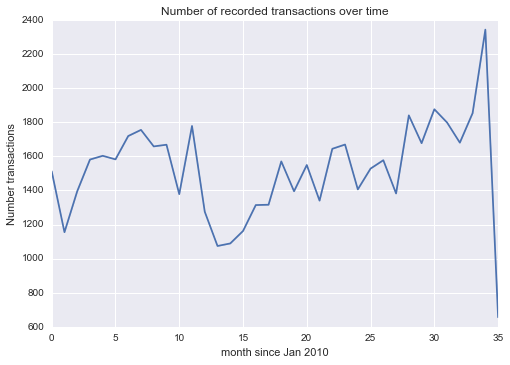

In [5]:
def format_month(x):
    if x.month < 10:
        return '0' + str(x.month)
    else:
        return str(x.month)
transactions_by_month = data['Date'].apply(lambda x: str(x.year) + '_' + format_month(x)).value_counts(sort=False)
transactions_by_month.sort_index()
ax = sns.tsplot(data=transactions_by_month.sort_index())
sns.axlabel("month since Jan 2010", "Number transactions")
ax.set_title("Number of recorded transactions over time")

**The number of transactions per month fluctuates between 1100 and 2400. There is no clear trend, but some peaks and valleys are apparent from the picture.**

### 2.2 Transaction price over time

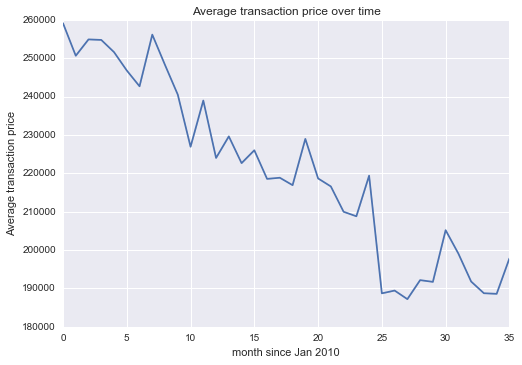

In [6]:
avgprice_by_month = data.groupby(['Year_Month'])['FullPrice'].mean()
ax = sns.tsplot(data=avgprice_by_month.sort_index())
sns.axlabel("month since Jan 2010", "Average transaction price")
ax.set_title("Average transaction price over time")

**Transaction prices decreased quite substantially over the time period form 2010 until the end of 2012. This is consistent with aggregate statistics on the Irish housing marketing that indicate a 10-12% annual price decrease over this period. This indiates that time is a relevant feature for price prediction.**

### 2.3 Price distribution

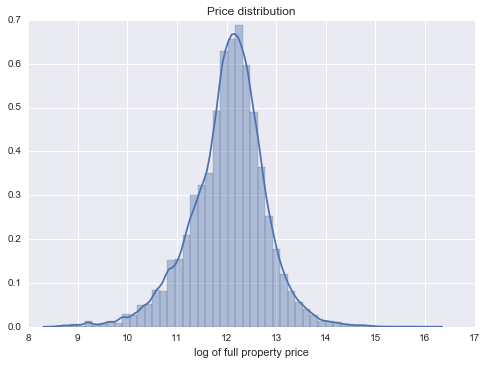

In [7]:
data['LogFullPrice'] = np.log(data.FullPrice)
ax = sns.distplot(data.LogFullPrice)
sns.axlabel("log of full property price", "")
ax.set_title("Price distribution")

**The log of the full transaction price closely follows a normal distribution with mean around 12.2, corresponding to a mean property price around EUR200000.**

### 2.4 Crime intensity and prices

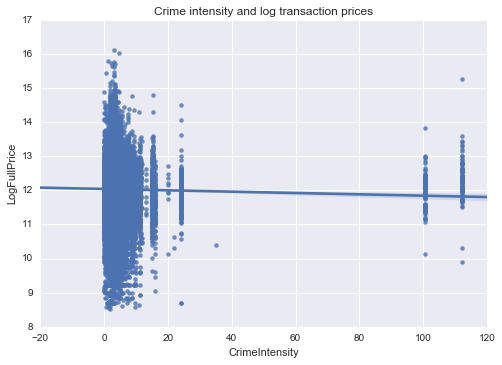

In [8]:
ax = sns.regplot(x="CrimeIntensity", y="LogFullPrice", data=data)
ax.set_title("Crime intensity and log transaction prices")

**As expected, transaction prices tend to decrease with crime intensities. The effect is not very strong, however. There is some visible clustering, with high crime urban areas to the right and the majority of other areas to the left.**

### 2.5 Local annual income per capita and prices

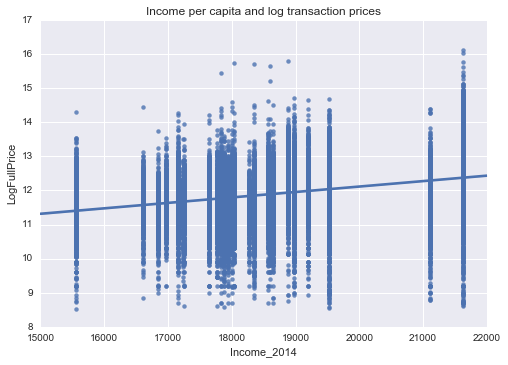

In [9]:
ax = sns.regplot(x="Income_2014", y="LogFullPrice", data=data)
ax.set_title("Income per capita and log transaction prices")

**Income per capita has a quite strong effect on property prices. In areas with annual income per capita of around EUR15.500, the average property price is around EUR90.000. In areas with an income that is EUR5.000 higher (EUR20.500), the average transaction price is almost EUR200.000. That is, the difference is more than 100% for EUR5.000 more in annual income.   **

### 2.6 Five-year-growth of annual income per capita and prices

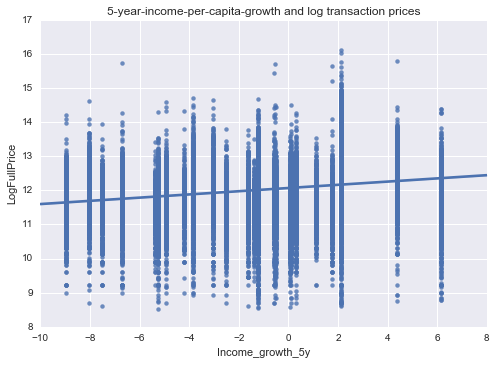

In [10]:
ax = sns.regplot(x="Income_growth_5y", y="LogFullPrice", data=data)
ax.set_title("5-year-income-per-capita-growth and log transaction prices")

**Income per capita growth has a surprinsingly strong effect on property prices.**

### 2.7 Property size and price

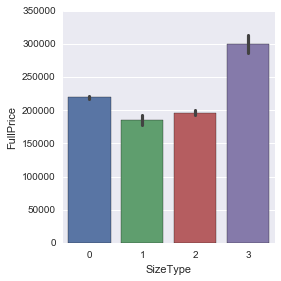

In [11]:
data['SizeType'] = 3*data['SizeBig'] + 2*data['SizeMedium'] + 1*data['SizeSmall']
g = sns.factorplot(x="SizeType", y="FullPrice", data=data, kind="bar")

**Big properties (SizeType=3) have a price premium over medium-sized ones (SizeType=2), which in turn have a small premium over small ones (SizeType=1). Properties for which no size information is available (SizeType=0) are presumably of various sizes and thus have an average price. **

### 2.8 Counts of transactions for new and existing properties

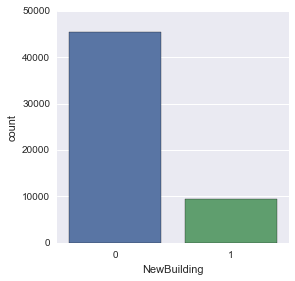

In [12]:
g = sns.factorplot(x="NewBuilding", data=data, kind="count")

**Only about 20% of property transactions involve new/recently constructed buildings.**

### 2.9 Average price for new and existing properties

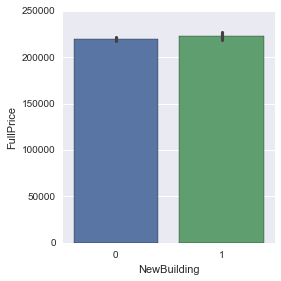

In [13]:
g = sns.factorplot(x="NewBuilding", y='FullPrice', data=data, kind="bar")

**There is practically no price difference between transaction prices of new and old properties.**

# 3. Selecting an algorithm for price prediction

**In this section, we use the sklearn-package and apply various regression algorithms to the property price data. The goal is to understand how various algorithms perform on this dataset and to select some algorithms for hyperparameter tuning in a later stage. Specifically, we compare linear regression, support vector regression, nearest neighbor regression, decision tree regression, random forest and adaboost. These algorithms are selected because we are dealing with a regression problem and hence need an algorithm that can deal with a continuous target. **

## 3.1 Extract, preprocess and split data in training, validation and test set

**We split the data into a training, validation and test set. The training set is used for training the regression algorithms and the validation set is used for performance evaluation and for deciding on a certain algorithm to use for hyperparameter tuning. The test set is only used for reporting performance of the tuned algorithm in the final section.**

In [14]:
# extract target and featues
target_label = 'LogFullPrice'
target = data[target_label].values
data['LogIncome_2014'] = np.log(data.Income_2014)
data['LogClosedCenterDist'] = np.log(data.ClosestCenterDist)
features_labels = ['LogIncome_2014', 'Income_growth_5y', 'LogClosedCenterDist', 'CrimeIntensity', 'NewBuilding', 'SizeBig', 'SizeMedium', 'SizeSmall']
features = data.as_matrix(columns=features_labels)
# add county dummies
county_dummies = pd.get_dummies(data.County).as_matrix()
features = np.concatenate((features, county_dummies), axis=1)
# add time dummies
time_dummies = pd.get_dummies(data.Year_Month).as_matrix()
features = np.concatenate((features, time_dummies), axis=1)
# split data in training (60 %), validation (30%) and test set (10%)
X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(features, target, test_size=0.4, random_state=19)
X_validation, X_test, y_validation, y_test = cross_validation.train_test_split(X_validation, y_validation, test_size=0.25, random_state=32)

## 3.2 Basic linear regression and a regression with Lasso regularization

**As a first step, we perform a linear regression on the dataset. Even though we do not expect a good fit by imposing a globally linear regression surface on such a large dataset, linear regression is quick to perform and can serve as a useful benchmark. We also report results for linear regression with Lasso regularization. Since there are not too many features in this problem, we do not expect a significantly better performance with Lasso (and actually observe deteriorating performance). **

In [97]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
predicted_values = lin_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for linear regression is %f' % (mse))

The mean squared error for linear regression is 0.404015


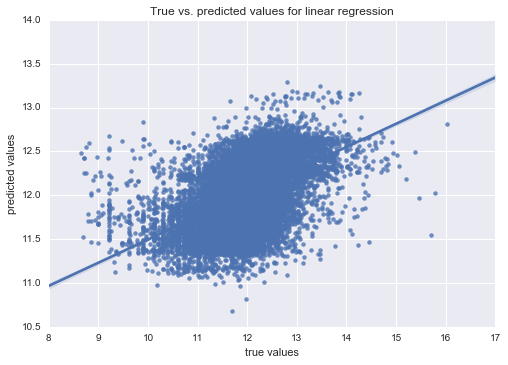

In [16]:
#seaborn.regplot(y_validation, predicted_values)
g = sns.regplot(x=y_validation, y=predicted_values)
sns.axlabel("true values", "predicted values")
g.set_title("True vs. predicted values for linear regression")

In [17]:
lin_reg_lasso = linear_model.Lasso(alpha=0.05)
lin_reg_lasso.fit(X_train, y_train)
predicted_values = lin_reg_lasso.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for linear regression with lasso regularization is %f' % (mse))

The mean squared error for linear regression with lasso regularization is 0.473450


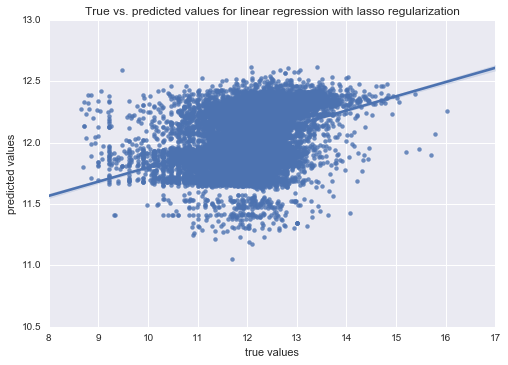

In [18]:
g = sns.regplot(x=y_validation, y=predicted_values)
sns.axlabel("true values", "predicted values")
g.set_title("True vs. predicted values for linear regression with lasso regularization")

## 3.3 Support vector regressions with different kernel and parameter choices

**A support vector regression estimates coefficients by minimizing a cost function that only considers the costs of obsverations with residuals larger than a certain threshold. Also, the SVR optimization problem includes a term for regularization / overfitting-prevention. It is hard to guess a priori how SVR will perform in terms of predictive accuracy on this dataset. After performing some experiments, we find that predictive performance is rather good, but the running time is slow.**

In [19]:
svm_reg = svm.SVR(kernel='rbf', C=10)
svm_reg.fit(X_train, y_train)
predicted_values = svm_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for support vector regression with the given parameters is %f' % (mse))

The mean squared error for support vector regression with the given parameters is 0.366141


In [20]:
svm_reg = svm.SVR(kernel='rbf', C=1)
svm_reg.fit(X_train, y_train)
predicted_values = svm_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for support vector regression with the given parameters is %f' % (mse))

The mean squared error for support vector regression with the given parameters is 0.369195


In [21]:
svm_reg = svm.SVR(kernel='linear', C=1)
svm_reg.fit(X_train, y_train)
predicted_values = svm_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for support vector regression with the given parameters is %f' % (mse))

The mean squared error for support vector regression with the given parameters is 0.407674


In [22]:
svm_reg = svm.SVR(kernel='sigmoid', C=1)
svm_reg.fit(X_train, y_train)
predicted_values = svm_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for support vector regression with the given parameters is %f' % (mse))

The mean squared error for support vector regression with the given parameters is 0.550699


## 3.4 K-nearest neighbors regression

**K-Nearest neighbors regression computes the target value of a given point by finding the k closest points in the feature space and by computing an average value of the targets for the closest points. Various weighting functions can be used for computing the average, where uniform weights and weights that decay in some way with distance are commonly used. We expect this algorithm to perform rather well, since it is basically nonparametric and can capture local and global nonlinearities in the prediction surface rather well (depending on the choice of neighbors). We indeed observe a good performance of this algorithm, both in terms of accuracy and speed (as long as the number of neighbors is not large).  **

In [23]:
nn_reg = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
nn_reg.fit(X_train, y_train)
predicted_values = nn_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for the nearest neighbor regression with the given parameters is %f' % (mse))

The mean squared error for the nearest neighbor regression with the given parameters is 0.449953


In [24]:
nn_reg = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
nn_reg.fit(X_train, y_train)
predicted_values = nn_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for the nearest neighbor regression with the given parameters is %f' % (mse))

The mean squared error for the nearest neighbor regression with the given parameters is 0.407070


The mean squared error for the nearest neighbor regression with the given parameters is 0.365360


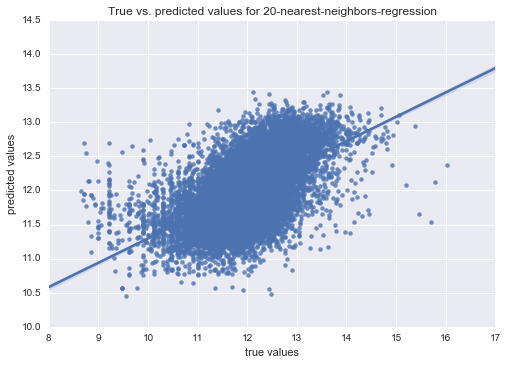

In [32]:
nn_reg = neighbors.KNeighborsRegressor(n_neighbors=20, weights='uniform')
nn_reg.fit(X_train, y_train)
predicted_values = nn_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for the nearest neighbor regression with the given parameters is %f' % (mse))
g = sns.regplot(x=y_validation, y=predicted_values)
sns.axlabel("true values", "predicted values")
g.set_title("True vs. predicted values for 20-nearest-neighbors-regression")

## 3.5 Decision tree regression

**Decision tree regression builts a decision tree based on the importance and magnitude of features and thus splits the data based on various criteria. We find that the predictive performance of a single decision tree is rather week.**

In [26]:
dt_reg = tree.DecisionTreeRegressor(criterion='mse', splitter='best')
dt_reg.fit(X_train, y_train)
predicted_values = dt_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for the decision tree regression is %f' % (mse))

The mean squared error for the decision tree regression is 0.585897


## 3.6 Random forest

**A random forest algorithm for regression is an ensemble method that combines various decision trees (based on random feature selection) and reports the average target value of the combined trees as prediction. Since random forests are often used for price prediction, we expect and observe a good performance of this algorithm on the validation set. **

In [27]:
rf_reg = ensemble.RandomForestRegressor(n_estimators=10, criterion='mse')
rf_reg.fit(X_train, y_train)
predicted_values = rf_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for the decision tree regression is %f' % (mse))

The mean squared error for the decision tree regression is 0.386495


The mean squared error for the decision tree regression is 0.376482


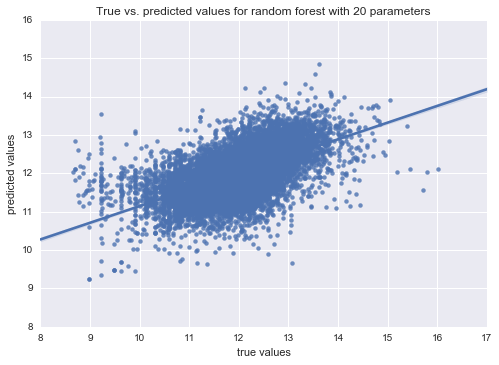

In [33]:
rf_reg = ensemble.RandomForestRegressor(n_estimators=20, criterion='mse')
rf_reg.fit(X_train, y_train)
predicted_values = rf_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for the decision tree regression is %f' % (mse))
g = sns.regplot(x=y_validation, y=predicted_values)
sns.axlabel("true values", "predicted values")
g.set_title("True vs. predicted values for random forest with 20 parameters")

## 3.7 Adaboost

**Finally, we apply a boosting algorithm to the dataset. Boosting algorithms are ensemble methods that combine more classifiers based on how well the algorithm is able to predict a a certain value already. That is, they tend to focus on observations the algorithm got wrong previously. We expected a very good performance, but observe that Adaboost only leads to a decent performance on the validation set.**

In [29]:
ada_reg = ensemble.AdaBoostRegressor(n_estimators=20, learning_rate=0.1, loss='square')
ada_reg.fit(X_train, y_train)
predicted_values = ada_reg.predict(X_validation)
mse = mean_squared_error(y_validation, predicted_values)
print('The mean squared error for the decision tree regression is %f' % (mse))

The mean squared error for the decision tree regression is 0.411728


## 3.8 Overview of results

** The table below summarizes the predictive performance measured by performing predictions on the validation set and computing the MSE for the different algorithms. Some algorithms perform significantly better compared to the benchmark case linear regression, whereas other improve the MSE only slightly or not at all. Based on this results, we select KNN- and RandomForest-Regression, because they perform well in terms of prediction and can be computed rather quickly on this dataset. Even though SVR has good predictive performance, it is not selected for hyperparameter tuning because the SVR-training time on this dataset is rather high compared to the other algorithms. **

| Algorithm                  | MSE           | 
| :------------------------- |--------------:|
| Linear Regression          |  0.404        |
| Linear Regression (Lasso)  |  0.473        |
| SVR(kernel='rbf', C=10)    |  0.366        |
| SVR(kernel='rbf', C=1)     |  0.369        |
| SVR(kernel='linear', C=1)  |  0.408        |
| SVR(kernel='sigmoid', C=1) |  0.551        |
| KNN(neighb=5, weights='distance') |  0.450 |
| KNN(neighb=5, weights='uniform') |  0.407 |
| KNN(neighb=20, weights='uniform') |  0.365 |
| DecisionTree |  0.586 |
| RandomForest(estimators=10) |  0.386 |
| RandomForest(estimators=20) |  0.376 |
| Adaboost(estimators=20, lr=0.1) |  0.412 |

# 4. Tune algorithm for price prediction

**The goal of this section is to perform hyperparameter tuning for the best-performing algorithms in the previous section, KNN and RandomForest. The hyperparameters we find are used in the next section for reporting the performance of the algorithms on the test set.**

In [48]:
# combine training and validation set (reason: sklearn's GridSearchCV automatically performs cross validation with 3-folds (default))
X_tuning = np.append(X_train, X_validation, axis=0) 
y_tuning = np.append(y_train, y_validation, axis=0) 

In [67]:
# tune KNN-parameters
param_grid = {'n_neighbors': [5,10,15,20,25,30,40], 'weights': ['uniform','distance'], 'p':[1,2]}
nn_reg = neighbors.KNeighborsRegressor()
nn_tune = grid_search.GridSearchCV(nn_reg, param_grid, scoring='mean_squared_error')
nn_tune.fit(X_tuning, y_tuning)
print('*** Best KNN-Estimator ***', '\nNeighbors: ', nn_tune.best_estimator_.n_neighbors, '\nWeights: ', nn_tune.best_estimator_.weights, '\np: ', nn_tune.best_estimator_.p)

*** Best KNN-Estimator *** 
Neighbors:  30 
Weights:  uniform 
p:  2


In [87]:
# tune Random-forest-parameters
param_grid = {'n_estimators': [10,20,30,40,50,60,70,80,90,100], 'criterion':['mse']}
rf_reg = ensemble.RandomForestRegressor()
rf_tune = grid_search.GridSearchCV(rf_reg, param_grid)
rf_tune.fit(X_tuning, y_tuning)
print('*** Best random forest estimator ***', '\nN_Estimators: ', rf_tune.best_estimator_.n_estimators)

*** Best random forest estimator *** 
N_Estimators:  100


# 5. Apply tuned algorithm to test set and compute squared error

**In this final section, we the report predicitive precision on the test set for the best algorithms selected from the selection and tuning stages. This step can be considered as a final robustness check, since the algorithms are applied to previously unused data. This step effectively rules out artificially high performance due to overfitting. **

In [90]:
# KNN
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=30, weights='uniform', p=2)
knn_reg.fit(X_tuning, y_tuning)
predicted_values = knn_reg.predict(X_test)
mse = mean_squared_error(y_test, predicted_values)
print('The mean squared error for the tuned nearest neighbor regression on the test set is %f' % (mse))

The mean squared error for the tuned nearest neighbor regression on the test set is 0.373447


In [98]:
# Random forest
rf_reg = ensemble.RandomForestRegressor(n_estimators=100, criterion='mse')
rf_reg.fit(X_tuning, y_tuning)
predicted_values = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, predicted_values)
print('The mean squared error for the tuned random forest regression on the test set is %f' % (mse))

The mean squared error for the tuned random forest regression on the test set is 0.370932


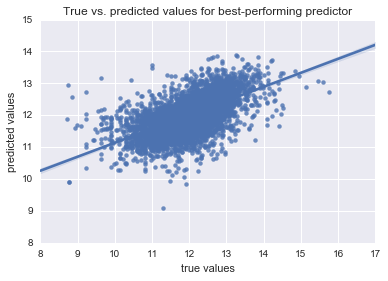

In [99]:
# plot predicted and actual values for best-performing predictor
g = sns.regplot(x=y_test, y=predicted_values)
sns.axlabel("true values", "predicted values")
g.set_title("True vs. predicted values for best-performing predictor")

** Result**

**We find that the optimized random forest algorithm performs best on the test set with an MSE of 0.369 and thus is selected as the most accurate predictor (in a mean-squared-sense) for log-house-prices in Ireland based on our analysis. This result confirms the expectation that random forest algorithms generally perform well for property price predictions. **

** Discussion and suggestions for improvements **

**In this project, we have constructed an appropriate dataset and evaluated several machine learning algorithms for regression problems to accurately predict property transaction prices. One of the challenges of this project was to creativly use additional data to construct features that are important predictors for property prices, especially due to the lack of meaningful feature variation in the original property price dataset. By geocoding the transactions and by using public datasources on local social and economic conditions in Ireland, additional features could be constructed and matched to the properties and their locations. The exploratory analysis revealed that features such as local income per capita and income growth are indeed related to property prices and thus have predictive power.**

**The above visualization of true vs. predicted values for the best performing algorithm reveals that most points cluster along the diagonal, as one would expect. However, some points are quite far off from the cloud and could potentially be considered outliers. Taking a closer look at the transactions behind these outliers may not change our result for the optimal algorithm, but may provide further valuable insight into the dataset. Another more ambitious way of improving the project is to scan pictures of the properties at each address, using for example Google StreetView, and use a deep learning algorithm to identify features on images that give a good proxy for property size such as the number of windows and the like.  **

# Appendix

**SOURCES**

Residential Property Price Register, Property Services Regulatory Authority, Ireland: https://www.propertypriceregister.ie

National Police Service Ireland, List and GPS locations of police stations, http://www.garda.ie/stations/Default.aspx

Central Statistics Office, Ireland, http://www.cso.ie/en/index.html

Google GeoCoding API, https://developers.google.com/maps/documentation/geocoding/intro